# ASSIGNMENT 2                                                McGill COMP451 
Brennan King (260953180) - **Kaggle account number: 22597792**

- Did you discuss your solution with classmates?
nope
- If yes, please list their names here: 
- Did you use LLMs such as chatGPT?
yes
- If yes, please explain how:
I used chat GPT to learn more about architecture of machine learning models and why you might want to use more or less layers/units. I also asked it questions about the different hyperparameters and what tweaking them might do to the fit/performance of my model.

Note that you should not share any code with your classmates, but you can discuss your solution. This is an individual assignment. The team ID above is only needed because we need to link your report to your Kaggle submission.

For this assignment, there are a few rules to keep things fair and help you focus on the core problem. You shouldn’t use large pre-trained models (like those with over X million parameters) so that everyone is building their own solutions. Also, avoid using external APIs like ChatGPT to generate extra data or solve equations. Stick to the provided data—no outside data for training is allowed. 

**Note:** you can submit the report with delay and have the usual late day penalty (which has 5/20 pts). The competition, which is the main part of this assignment (15/20 pts), will close at the exact submission deadline, and ** late submissions are not accepted **. So please start early! 

## Objective
The objective of this assignment is to give you hands-on experience with deep learning packages, such as PyTorch. The task here is to build a model that takes an image as input and produces a single number. The image contains an equation including addition or multiplication of two variables (e.g., a + b and a × b). The values of a and b will range from 1 to 4, keeping the math simple and focusing more on the vision task. The output of the model should be output of the equation. It is up to you to choose the model architecture. You may approach this as a classification task since the output options are limited, or consider it as a regression task. The assignment has two deliverables: 
- You need to upload your prediction for the test set to Kaggle in order to participate in the competition.
- You need to complete this notebook which is considered a report of your methodolgoy.

# Kaggle Competition
You get access to the Kaggle competition using the following url
[https://www.kaggle.com/t/38979e6982264ddaadc0977da531b89a](https://www.kaggle.com/t/38979e6982264ddaadc0977da531b89a).
Training and test data are available as a part of the assignment in the datasets folder. To participate in the competition you should upload a CSV file containing your predicted label for the entire test data to Kaggle. 
The test data is divided in half. You receive the correct label for the first half (in datasets folder), so that you can evaluate your model in this notebook on that part of the test set. You then submit your solution for the entire test set to Kaggle. The final evaluation is based on your predictions for the second part of the test set (private leaderboard). We have step-by-step explanation in the final section of this notebook.

# Report
The purpose of this notebook is for you to provide a concise report of your methodology. That is you need to include all steps necessary to reproduce your results. Please include high level explanation of the implementation so that we can understand what you're trying to achieve in each piece of the code.

**Note:** You need to submit this notebook where you have run all the cells as part of Assignment 2. **We should not need to rerun your code since this can take a long time.** You can use your Google cloud credit towards this assignment, to get better GPU access for example, using Google colab. Ask for help if you want to do this.

## Grading (20 pts)
The grading for this assignment has two components
- **Performance in the private leaderboard** (**15 pts**)
    - Have you correctly implemented a **deep model** and correctly trained in on the dataset (**5pts**). Note that this means your solution discussed in this report has to be a deep model, implemented using automatic differentiation packages such as PyTorch, Jax or Tensorflow.
    - a linear grade based on your relative accuracy: $10 \times \frac{acc_{you}}{acc_{best}}$ -- where $acc_{best}$ is the accuracy of the best model in our class (**10pts**). So if you have 40% accuracy on the private leaderboard and the best model has 80% accuracy, you will receive $10\times \frac{40}{80} = 5$ points.
    -  Top 3 participants in the private leaderboard receive a bonuses of 5, 3, 1 pts. If your total grade is over 20pts your bonus will be carried over to your final grade.
- **Quality of Your Report** (**5pts**)
    - Is your report clear and concise? 
    - do you have a minimal yet clear explanation for each step? Also, if you are using routines that are trivial and can be separated into a another python file you can do this in favour of better readability and minimality of the notebook. 
    - Do your design choices make sense? Are they justified?
    - If you tried several ideas, try to focus your report on the final one that is used in your final submission. You can quickly mention what other ideas you tried and discarded if that is the case.

**Note:** if the results in the final part of this report does not match the CSV file that you uploaded to Kaggle you will not receive any points for the assignment.

## Step 1 - the dataset
Use the following code to load the data using the npy files. We have 11,000 training examples, where each image is 50x80. Each image contains an equation of form $A + B$ or $A \times B$ and digists $A,B \in \{1,2,3,4\}$, and the label is the output of the equation in each image. The label is printed at the top of each example shown below.

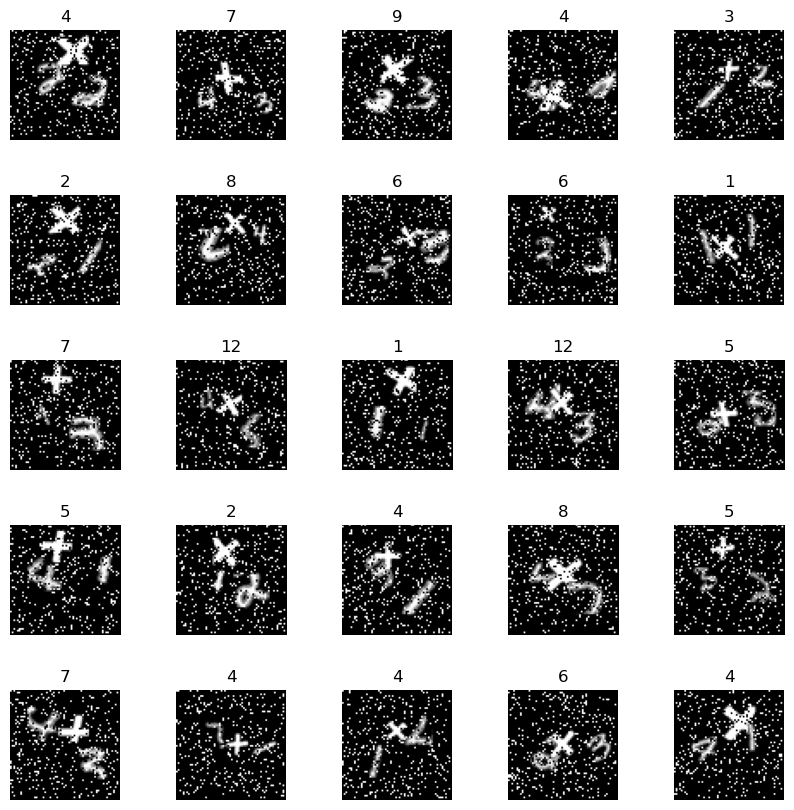

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
x = np.load('datasets/x_train.npy')  # 11,000 x 64 x 64
y = np.load('datasets/y_train.npy')

# Define function to plot images
def plot_digits(x, y):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 grid
    fig.subplots_adjust(hspace=0.5, wspace=0.5)       # Space between images

    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i], cmap='gray')
        ax.set_title(str(y[i]))
        ax.axis('off')  # Remove axes

    plt.show()

# Plot the first 25 instances in the dataset
plot_digits(x[:25], y[:25])

## Step 2 - preprocessing 

Your report should contain any potential preprocessing that you have done on the dataset. If you haven't performed any preprocessing, please leave this empty. This includes any sample code that you will use. 


MY NOTES:
The images have quite a lot of noise, so I removed this before my training and testing to make the numbers and the mathematical symbols easier to detect.

Note that I have also placed a manual seed so that there is no randomness in my model between different trainings. This makes it easier to track the improvement of my model as I tuned hyperparameters/messed around with the architecture.

In [6]:
# Imports
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2

import cv2
# ipyhton debugger
import pdb

from torch.optim.lr_scheduler import ExponentialLR

torch.manual_seed(22)

In [7]:
def preprocess_image(image_array):
    # I messed around with a bunch of different filters, but the combination of these two seemed to work best to eliminate
        # the noise while maintaining the integrity of the numbers and symbols
    # Step 1: Apply Median Filter
    denoised_image = cv2.medianBlur(image_array, 3)
    
    # Step 2: Apply Gaussian Smoothing
    blurred_image = cv2.GaussianBlur(denoised_image, (3, 3), 0)

    return blurred_image

# Apply preprocessing to each image in the dataset
x = np.array([preprocess_image(image) for image in x])

# Step 3 - the model and its training
This is the main part of your report. Below we provide an example, where we apply a logistic regression model to the dataset, and we get a very bad accuracy. You can do much better! You also have to use a deep learning package in your solution. Provide the explanation for your model and its training below. 

## 3.1 example code (not using PyTorch)
The code below shows the performance of a logistic regression model which will be used as a base model in this case. 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
features = x.reshape(11000,-1) #vectorizing the input image
labels = y.reshape(-1,1)
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.33, random_state=42) #set aside 33% of the data for validation
clf = LogisticRegression()
clf.fit(x_train,y_train)
predictions = clf.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("The validation accuracy of the model is", accuracy*100, '%')

The validation accuracy of the model is 14.490358126721764 %


## 3.2 your model!

 You should choose the final learning model that you have used to submit your solutions to Kaggle. For your chosen model provide the implementation code in this notebook along with the detail. Details should include the architecture and the choice of hyperparameters. If you performed a hyperparameter search you should explain it here.

you can start here in the same cell!


In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Here I am defining the model architecture.
        # Three convolutional layers and two fully connected layers.

        # First convolutional layer takes 1 input and outputs 32 convolutional features
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 16)
        # I implemented dropout to increase the generalizability of my model
        self.dropout = nn.Dropout(0.4)

    # Here is the forward pass through each layer of the network
    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv2(x), 2))
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv3(x), 2))
        
        x = x.view(x.size(0), -1)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model, loss, optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Not using the scheduler at the moment
##scheduler = ExponentialLR(optimizer, gamma=0.97)

# Define transformations for training
train_transform = v2.Compose([
    v2.RandomRotation(10),
    v2.RandomResizedCrop(64, scale=(0.9, 1.0)),
])

# This class takes the images and their labels and then it combines them into a dataset.
# There is an option to apply transformations to the images if one wants to augment the data.
# At the moment, the data augmentation isn't working. I haven't found a transformation that
    # is able to lead to a model that performs better on the test set...
class EquationDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.data = x_data
        self.labels = y_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].float() # Do I need to be converting this into a float?
        label = self.labels[idx]

        # If I'm choosing to augment the data, then I want to apply the random transformations to the images
        if self.transform:
            image = self.transform(image)
        
        return image, label



# Load dataset
x_train = x
y_train = y - 1  # Shift labels to range 0-15

# NOTE: I KNOW THAT THIS ISN'T A VERY ELEGANT WORK AROUND,
# BUT I KEPT GETTING TOLD THAT LABEL=16 WAS CAUSING AN INDEX OUT OF BOUND ERROR

x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.long)


# Load test data
x_test_half = np.load('datasets/x_test.npy')[:4500]  # Use only the first 4500 for which labels are available
y_test_half = np.load('datasets/y_test.npy')[:4500]

# Dealing with the index shift here
y_test_half = y_test_half - 1
x_test_half = np.array([preprocess_image(image) for image in x_test_half])

# Convert test data to PyTorch tensors and reshape for the model
x_test_half = torch.tensor(x_test_half, dtype=torch.float32).unsqueeze(1)  # Shape: (4500, 1, 64, 64)
y_test_half = torch.tensor(y_test_half, dtype=torch.long)  # Shape: (4500,)


# Combine training and test data to have a larger dataset to train on.
# This was done after hyperparameter selection
combined_x = torch.cat([x_train, x_test_half])
combined_y = torch.cat([y_train, y_test_half])


train_dataset = EquationDataset(combined_x, combined_y, train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

training_loss = []

# Training loop with validation tracking
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    # My model always seems to perform worse when I have a scheduler, no matter the parameters
    # scheduler.step()

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print loss for every epoch
    training_loss.append(running_loss / len(train_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/20], Loss: 2.2697
Epoch [2/20], Loss: 1.9331
Epoch [3/20], Loss: 1.7621
Epoch [4/20], Loss: 1.6346
Epoch [5/20], Loss: 1.5319
Epoch [6/20], Loss: 1.4413
Epoch [7/20], Loss: 1.3562
Epoch [8/20], Loss: 1.2890
Epoch [9/20], Loss: 1.2204
Epoch [10/20], Loss: 1.1470
Epoch [11/20], Loss: 1.0949
Epoch [12/20], Loss: 1.0608
Epoch [13/20], Loss: 1.0229
Epoch [14/20], Loss: 0.9748
Epoch [15/20], Loss: 0.9699
Epoch [16/20], Loss: 0.9051
Epoch [17/20], Loss: 0.9037
Epoch [18/20], Loss: 0.8841
Epoch [19/20], Loss: 0.8581
Epoch [20/20], Loss: 0.8487


# Step 4 - accuracy metrics and CSV submission to Kaggle

Here you can report accuracy metrics for the training and test sets. If you set aside a validation set you can report your accuracy on that set. Other plots such as training-validation loss plot over the training period can also be interesting to see here. A minimum here is the accuracy on the first half of the test set. **this number should match your public leaderboard accuracy**. **If this is not the case then your predictions here do not match what you reported on Kaggle and your submission is discarded!** This is because otherwise we can't establish that this code was used to produce the result of the leaderboard. Below we show this minimal report for the logistic regression classifier that we trained above.

MY NOTES:
I did not set aside a validation set from the training set. Instead, I used the first half of the test set as my validation set so that I could use as much data for the training as possible. I would then see how my model performed on the test set and then go back to my model to adjust the hyperparameters. Once I had my hyperparameters in a good spot, I added the first half of the test set to my training data to maximize the amount of data that I could train on.

These are the main hyperparameters that I played around with:
dropout
learning rate
optimizer type
batch size

I also tried different image processing techniques to make the images more legible, different transformations for data augmentation, and I tried to implement a learning rate scheduler (but for some reason this always led to worse performance on the test set).

In [38]:
# Testing on the test set to see how my model is performing on the public test data.

# Load test data (again)
x_test_half = np.load('datasets/x_test.npy')[:4500]  # Use only the first 4500 for which labels are available
y_test_half = np.load('datasets/y_test.npy')[:4500]

y_test_half = y_test_half - 1
x_test_half = np.array([preprocess_image(image) for image in x_test_half])

# Convert test data to PyTorch tensors and reshape for the model
x_test_half = torch.tensor(x_test_half, dtype=torch.float32).unsqueeze(1)  # Shape: (4500, 1, 64, 64)
y_test_half = torch.tensor(y_test_half, dtype=torch.long)  # Shape: (4500,)

model.eval()

# Disable gradient calculation for faster inference
with torch.no_grad():
    # Get model predictions
    outputs = model(x_test_half)
    _, predicted = torch.max(outputs, 1)  # Get the predicted class for each image

    # Calculate accuracy
    accuracy = (predicted == y_test_half).sum().item() / len(y_test_half) * 100
    print(f"The accuracy of the model that should match the public leaderboard accuracy is: {accuracy:.2f}%")


The accuracy of the model that should match the public leaderboard accuracy is: 84.42%


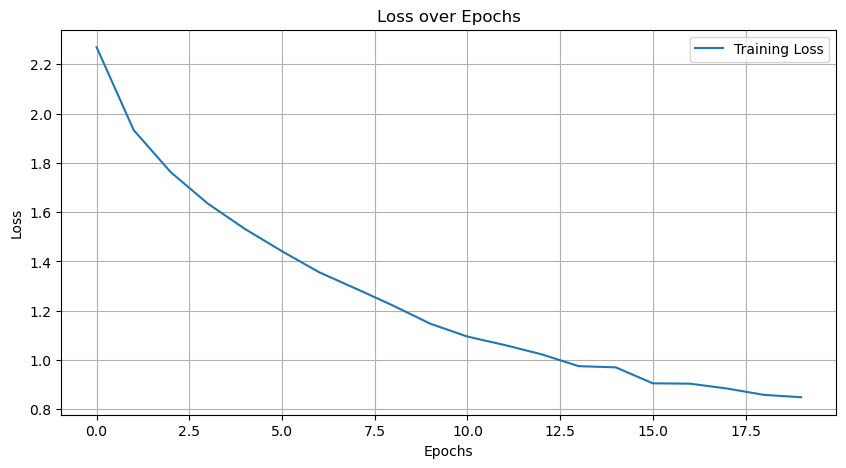

In [40]:
# >>> your code printing the test error on x_test_half

# Here I create a chart to show how the loss changes over the course of the training period
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()
    
    # <<< your code here

In order to submit your results to Kaggle you need to provide your predictions in CSV format. The code below shows how we do this for the example of logistic regression above. You can use the same method for your submission. Note that we need you to submit your result for the **entire test set** of size 9000. Your accuracy on the first half will show on the public leaderboard and the second half is on the private leaderboard that will be revealed when the competition is over. Submit the `predicted_labels.csv` to the Kaggle competition!  

In [36]:
import pandas as pd #you need to install pandas - also checkout what this package is good for while at it :]
def generate_csv_kaggle(y):
    indexes = np.arange(len(y))
    csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
    df = pd.DataFrame(csv_labels,columns=['Id','Category'])
    df['Id'] = df['Id'].astype(str)
    df['Category'] = df['Category'].astype(str)
    df.to_csv('predicted_labels.csv',index=False)
    pass

x_test = np.load('datasets/x_test.npy')
x_test = np.array([preprocess_image(image) for image in x_test])
# Convert test data to PyTorch tensors and reshape for the model
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Shape: (4500, 1, 64, 64)

model.eval()

# Store all of the predictions in an array so that they can be sent to a csv
predictions = []
with torch.no_grad():
    # Get model predictions
    outputs = model(x_test)
    _, predicted = torch.max(outputs, 1)  # Get the predicted class for each image
    predictions.extend(predicted.numpy())

yh_test = np.array(predictions) + 1
generate_csv_kaggle(yh_test)